# Loading skin lesion test set files and creating train/test functions

### Oversampling used to balance classes in train, valid, and test sets

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from glob import glob

# load filenames for human and dog images
melanoma_test_files = np.array(glob(r"D:\Python\Dermatology AI\data\even_class_size_test\melanoma\*"))
nevus_test_files = np.array(glob(r"D:\Python\Dermatology AI\data\even_class_size_test\nevus\*"))
seborrheic_keratosis_test_files = np.array(glob(r"D:\Python\Dermatology AI\data\even_class_size_test\seborrheic_keratosis\*"))

# print number of images in each dataset
print('There are %d total melanoma test set images.' % len(melanoma_test_files))
print('There are %d total nevus test set images.' % len(nevus_test_files))
print('There are %d total seborrheic keratosis test set images.' % len(seborrheic_keratosis_test_files))

There are 393 total melanoma test set images.
There are 393 total nevus test set images.
There are 393 total seborrheic keratosis test set images.


### Example melanoma image

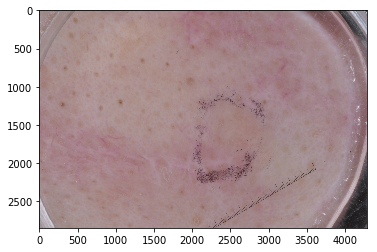

In [27]:
import cv2
img = cv2.imread(melanoma_test_files[0])
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

### Example nevus image

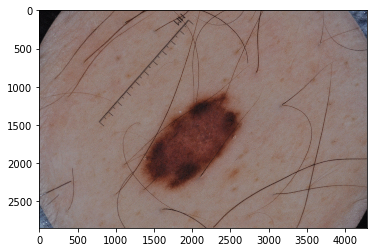

In [28]:
img = cv2.imread(nevus_test_files[0])
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

### Example seborrheic keratosis image

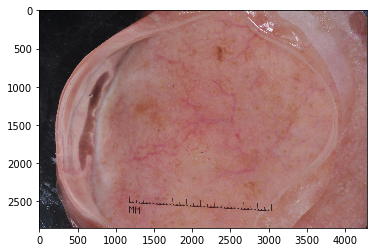

In [29]:
img = cv2.imread(seborrheic_keratosis_test_files[0])
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

In [2]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim

use_cuda = torch.cuda.is_available()

In [3]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import time

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
   
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
                
        start = time.time()
        
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                        
            #if batch_idx % 100 == 0:
                #print(epoch, ':', batch_idx, 'train_loss:', train_loss)
                
        end = time.time()
        print('Elapsed Epoch Training Time:', end - start)
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
      
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        # save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
     
    # return trained model
    return model


In [4]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

# The 4 most accurate recent neural network architectures (SENet-154, SE-ResNext-101, Inception-ResNetV2, and NASNet) will be trained and compared to Classify Skin Lesions with transfer learning from imagenet-1k data

# SE-Net154

In [5]:
## SE-Net154 uses 224x244 pretraining images

batch_size_SENet154 = 64

train_dir = r"D:\Python\Dermatology AI\data\even_class_size_train"
valid_dir = r"D:\Python\Dermatology AI\data\even_class_size_valid"
test_dir = r"D:\Python\Dermatology AI\data\even_class_size_test"

transform_transfer_SENet154 = transforms.Compose([transforms.Resize((224,224)),
                                                  transforms.ToTensor(), 
                                                  transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_set_transfer_SENet154 = datasets.ImageFolder(train_dir, transform=transform_transfer_SENet154)
train_loader_transfer_SENet154 = torch.utils.data.DataLoader(train_set_transfer_SENet154, 
                                                             shuffle=True, 
                                                             batch_size=batch_size_SENet154)

valid_set_transfer_SENet154 = datasets.ImageFolder(valid_dir, transform=transform_transfer_SENet154)
valid_loader_transfer_SENet154 = torch.utils.data.DataLoader(valid_set_transfer_SENet154, 
                                                             shuffle=True, 
                                                             batch_size=batch_size_SENet154)

test_set_transfer_SENet154 = datasets.ImageFolder(test_dir, transform=transform_transfer_SENet154)
test_loader_transfer_SENet154 = torch.utils.data.DataLoader(test_set_transfer_SENet154, 
                                                            shuffle=True, 
                                                            batch_size=batch_size_SENet154)

loaders_transfer_SENet154 = {'train':train_loader_transfer_SENet154, 
                             'valid': valid_loader_transfer_SENet154, 
                             'test':test_loader_transfer_SENet154}

In [6]:
# model architecture 
from __future__ import print_function, division, absolute_import
from collections import OrderedDict
import math

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils import model_zoo


__all__ = ['SENet', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152',
           'se_resnext50_32x4d', 'se_resnext101_32x4d']

pretrained_settings = {
    'senet154': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/senet154-c7b49a05.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet50': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet50-ce0d4300.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet101': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet101-7e38fcc6.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnet152': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnet152-d17c99b7.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext50_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext50_32x4d-a260b3a4.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
    'se_resnext101_32x4d': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/se_resnext101_32x4d-3b2fe3d8.pth',
            'input_space': 'RGB',
            'input_size': [3, 224, 224],
            'input_range': [0, 1],
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225],
            'num_classes': 1000
        }
    },
}


class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):
        """
        Parameters
        ----------
        block (nn.Module): Bottleneck class.
            - For SENet154: SEBottleneck
            - For SE-ResNet models: SEResNetBottleneck
            - For SE-ResNeXt models:  SEResNeXtBottleneck
        layers (list of ints): Number of residual blocks for 4 layers of the
            network (layer1...layer4).
        groups (int): Number of groups for the 3x3 convolution in each
            bottleneck block.
            - For SENet154: 64
            - For SE-ResNet models: 1
            - For SE-ResNeXt models:  32
        reduction (int): Reduction ratio for Squeeze-and-Excitation modules.
            - For all models: 16
        dropout_p (float or None): Drop probability for the Dropout layer.
            If `None` the Dropout layer is not used.
            - For SENet154: 0.2
            - For SE-ResNet models: None
            - For SE-ResNeXt models: None
        inplanes (int):  Number of input channels for layer1.
            - For SENet154: 128
            - For SE-ResNet models: 64
            - For SE-ResNeXt models: 64
        input_3x3 (bool): If `True`, use three 3x3 convolutions instead of
            a single 7x7 convolution in layer0.
            - For SENet154: True
            - For SE-ResNet models: False
            - For SE-ResNeXt models: False
        downsample_kernel_size (int): Kernel size for downsampling convolutions
            in layer2, layer3 and layer4.
            - For SENet154: 3
            - For SE-ResNet models: 1
            - For SE-ResNeXt models: 1
        downsample_padding (int): Padding for downsampling convolutions in
            layer2, layer3 and layer4.
            - For SENet154: 1
            - For SE-ResNet models: 0
            - For SE-ResNeXt models: 0
        num_classes (int): Number of outputs in `last_linear` layer.
            - For all models: 1000
        """
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        return x


def initialize_pretrained_model(model, num_classes, settings):
    assert num_classes == settings['num_classes'], \
        'num_classes should be {}, but is {}'.format(
            settings['num_classes'], num_classes)
    model.load_state_dict(model_zoo.load_url(settings['url']))
    model.input_space = settings['input_space']
    model.input_size = settings['input_size']
    model.input_range = settings['input_range']
    model.mean = settings['mean']
    model.std = settings['std']


def senet154(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEBottleneck, [3, 8, 36, 3], groups=64, reduction=16,
                  dropout_p=0.2, num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['senet154'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet50(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 6, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet50'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet101(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 4, 23, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet101'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnet152(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNetBottleneck, [3, 8, 36, 3], groups=1, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnet152'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext50_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model


def se_resnext101_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 23, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    if pretrained is not None:
        settings = pretrained_settings['se_resnext101_32x4d'][pretrained]
        initialize_pretrained_model(model, num_classes, settings)
    return model

In [7]:
model_transfer_SENet154 = senet154(pretrained='imagenet')

if use_cuda:
    model_transfer_SENet154 = model_transfer_SENet154.cuda()

In [16]:
model_transfer_SENet154

SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEBottleneck(
      (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 256,

In [8]:
SENet154_feature_layers = [model_transfer_SENet154.layer0.parameters(),
                           model_transfer_SENet154.layer1.parameters(),
                           model_transfer_SENet154.layer2.parameters(),
                           model_transfer_SENet154.layer3.parameters(),
                           model_transfer_SENet154.layer4.parameters()]

for parameters in SENet154_feature_layers:
    for param in parameters:
        param.requires_grad = False

In [9]:
n_inputs_SENet154 = model_transfer_SENet154.last_linear.in_features

output_classes_SENet154 = 3

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs_SENet154, output_classes_SENet154)

model_transfer_SENet154.last_linear = last_layer

if use_cuda:
    model_transfer_SENet154.cuda()

# check to see that your last layer produces the expected number of outputs
print(model_transfer_SENet154.last_linear.out_features)

3


In [10]:
import torch.optim as optim

use_cuda = torch.cuda.is_available()

criterion_transfer_SENet154 = nn.CrossEntropyLoss()
optimizer_transfer_SENet154 = optim.Adam(model_transfer_SENet154.last_linear.parameters())

### Train

In [17]:
# train the model
model_transfer_SENet154 =  train(30, 
                                 loaders_transfer_SENet154, 
                                 model_transfer_SENet154, 
                                 optimizer_transfer_SENet154, 
                                 criterion_transfer_SENet154, 
                                 use_cuda, 
                                 'model_transfer_SENet154.pt')

torch.save(model_transfer_SENet154.state_dict(), 'model_transfer_SENet154_last_epoch.pt')

Elapsed Epoch Training Time: 750.5839359760284
Epoch: 1 	Training Loss: 0.723000 	Validation Loss: 0.826100
Validation loss decreased (inf --> 0.826100).  Saving model ...
Elapsed Epoch Training Time: 735.4234762191772
Epoch: 2 	Training Loss: 0.608790 	Validation Loss: 0.825520
Validation loss decreased (0.826100 --> 0.825520).  Saving model ...
Elapsed Epoch Training Time: 709.9627225399017
Epoch: 3 	Training Loss: 0.555085 	Validation Loss: 0.853412
Elapsed Epoch Training Time: 709.3875734806061
Epoch: 4 	Training Loss: 0.515181 	Validation Loss: 0.804193
Validation loss decreased (0.825520 --> 0.804193).  Saving model ...
Elapsed Epoch Training Time: 720.6627323627472
Epoch: 5 	Training Loss: 0.474369 	Validation Loss: 0.810867
Elapsed Epoch Training Time: 720.1686971187592
Epoch: 6 	Training Loss: 0.454995 	Validation Loss: 0.843791
Elapsed Epoch Training Time: 716.1443438529968
Epoch: 7 	Training Loss: 0.440571 	Validation Loss: 0.863761
Elapsed Epoch Training Time: 713.863868713

### Test

In [18]:
model_transfer_SENet154.load_state_dict(torch.load('model_transfer_SENet154_last_epoch.pt'))

test(loaders_transfer_SENet154, model_transfer_SENet154, criterion_transfer_SENet154, use_cuda)

Test Loss: 1.016557


Test Accuracy: 64% (766/1179)


In [19]:
# Best perfroming epoch on validation set
model_transfer_SENet154.load_state_dict(torch.load('model_transfer_SENet154.pt'))

test(loaders_transfer_SENet154, model_transfer_SENet154, criterion_transfer_SENet154, use_cuda)

Test Loss: 0.846294


Test Accuracy: 64% (762/1179)


# SE-ResNext-101

In [6]:
## SE-ResNext-101 uses 224x224 pretraining images

batch_size_SEResNext101 = 128

train_dir = r"D:\Python\Dermatology AI\data\even_class_size_train"
valid_dir = r"D:\Python\Dermatology AI\data\even_class_size_valid"
test_dir = r"D:\Python\Dermatology AI\data\even_class_size_test"

transform_transfer_SEResNext101 = transforms.Compose([transforms.Resize((224,224)),
                                                      transforms.ToTensor(), 
                                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_set_transfer_SEResNext101 = datasets.ImageFolder(train_dir, transform=transform_transfer_SEResNext101)
train_loader_transfer_SEResNext101 = torch.utils.data.DataLoader(train_set_transfer_SEResNext101, 
                                                                  shuffle=True, 
                                                                  batch_size=batch_size_SEResNext101)

valid_set_transfer_SEResNext101 = datasets.ImageFolder(valid_dir, transform=transform_transfer_SEResNext101)
valid_loader_transfer_SEResNext101 = torch.utils.data.DataLoader(valid_set_transfer_SEResNext101, 
                                                                 shuffle=True, 
                                                                 batch_size=batch_size_SEResNext101)

test_set_transfer_SEResNext101 = datasets.ImageFolder(test_dir, transform=transform_transfer_SEResNext101)
test_loader_transfer_SEResNext101 = torch.utils.data.DataLoader(test_set_transfer_SEResNext101, 
                                                                shuffle=True, 
                                                                batch_size=batch_size_SEResNext101)

loaders_transfer_SEResNext101 = {'train':train_loader_transfer_SEResNext101, 
                                 'valid': valid_loader_transfer_SEResNext101, 
                                 'test':test_loader_transfer_SEResNext101}

In [7]:
model_transfer_SEResNext101 = se_resnext101_32x4d(pretrained='imagenet')

if use_cuda:
    model_transfer_SEResNext101 = model_transfer_SEResNext101.cuda()

In [9]:
model_transfer_SEResNext101

SENet(
  (layer0): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  )
  (layer1): Sequential(
    (0): SEResNeXtBottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (se_module): SEModule(
        (avg_po

In [8]:
SEResNext101_feature_layers = [model_transfer_SEResNext101.layer0.parameters(),
                               model_transfer_SEResNext101.layer1.parameters(),
                               model_transfer_SEResNext101.layer2.parameters(),
                               model_transfer_SEResNext101.layer3.parameters(),
                               model_transfer_SEResNext101.layer4.parameters()]

for parameters in SEResNext101_feature_layers:
    for param in parameters:
        param.requires_grad = False

In [9]:
n_inputs_SEResNext101 = model_transfer_SEResNext101.last_linear.in_features

output_classes_SEResNext101 = 3

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs_SEResNext101, output_classes_SEResNext101)

model_transfer_SEResNext101.last_linear = last_layer

if use_cuda:
    model_transfer_SEResNext101.cuda()

# check to see that your last layer produces the expected number of outputs
print(model_transfer_SEResNext101.last_linear.out_features)

3


In [10]:
import torch.optim as optim

use_cuda = torch.cuda.is_available()

criterion_transfer_SEResNext101 = nn.CrossEntropyLoss()
optimizer_transfer_SEResNext101 = optim.Adam(model_transfer_SEResNext101.last_linear.parameters())

### Train

In [11]:
model_transfer_SEResNext101 =  train(30, 
                                     loaders_transfer_SEResNext101, 
                                     model_transfer_SEResNext101, 
                                     optimizer_transfer_SEResNext101, 
                                     criterion_transfer_SEResNext101, 
                                     use_cuda, 
                                     'model_transfer_SEResNext101.pt')

torch.save(model_transfer_SEResNext101.state_dict(), 'model_transfer_SEResNext101_last_epoch.pt')

Elapsed Epoch Training Time: 689.8697435855865
Epoch: 1 	Training Loss: 0.836706 	Validation Loss: 0.802290
Validation loss decreased (inf --> 0.802290).  Saving model ...
Elapsed Epoch Training Time: 670.7575771808624
Epoch: 2 	Training Loss: 0.641664 	Validation Loss: 0.769331
Validation loss decreased (0.802290 --> 0.769331).  Saving model ...
Elapsed Epoch Training Time: 646.9339327812195
Epoch: 3 	Training Loss: 0.560524 	Validation Loss: 0.739808
Validation loss decreased (0.769331 --> 0.739808).  Saving model ...
Elapsed Epoch Training Time: 645.660407781601
Epoch: 4 	Training Loss: 0.503117 	Validation Loss: 0.732786
Validation loss decreased (0.739808 --> 0.732786).  Saving model ...
Elapsed Epoch Training Time: 649.0203530788422
Epoch: 5 	Training Loss: 0.460370 	Validation Loss: 0.775631
Elapsed Epoch Training Time: 648.7999384403229
Epoch: 6 	Training Loss: 0.428946 	Validation Loss: 0.736961
Elapsed Epoch Training Time: 649.3116085529327
Epoch: 7 	Training Loss: 0.400918 	

### Test

In [12]:
model_transfer_SEResNext101.load_state_dict(torch.load('model_transfer_SEResNext101_last_epoch.pt'))

test(loaders_transfer_SEResNext101, model_transfer_SEResNext101, criterion_transfer_SEResNext101, use_cuda)

Test Loss: 1.073793


Test Accuracy: 58% (690/1179)


In [13]:
# Best perfroming epoch on validation set
model_transfer_SEResNext101.load_state_dict(torch.load('model_transfer_SEResNext101.pt'))

test(loaders_transfer_SEResNext101, model_transfer_SEResNext101, criterion_transfer_SEResNext101, use_cuda)

Test Loss: 0.876672


Test Accuracy: 61% (727/1179)


# Inception-ResNetV2

In [5]:
## Inception_resNetV2 uses 299x299 pretraining images

batch_size_Inception_ResNetV2 = 128

train_dir = r"D:\Python\Dermatology AI\data\even_class_size_train"
valid_dir = r"D:\Python\Dermatology AI\data\even_class_size_valid"
test_dir = r"D:\Python\Dermatology AI\data\even_class_size_test"

transform_transfer_Inception_ResNetV2 = transforms.Compose([transforms.Resize((299,299)),
                                                            transforms.ToTensor(), 
                                                            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_set_transfer_Inception_ResNetV2 = datasets.ImageFolder(train_dir, transform=transform_transfer_Inception_ResNetV2)
train_loader_transfer_Inception_ResNetV2 = torch.utils.data.DataLoader(train_set_transfer_Inception_ResNetV2, 
                                                                       shuffle=True, 
                                                                       batch_size=batch_size_Inception_ResNetV2)

valid_set_transfer_Inception_ResNetV2 = datasets.ImageFolder(valid_dir, transform=transform_transfer_Inception_ResNetV2)
valid_loader_transfer_Inception_ResNetV2 = torch.utils.data.DataLoader(valid_set_transfer_Inception_ResNetV2, 
                                                                       shuffle=True, 
                                                                       batch_size=batch_size_Inception_ResNetV2)

test_set_transfer_Inception_ResNetV2 = datasets.ImageFolder(test_dir, transform=transform_transfer_Inception_ResNetV2)
test_loader_transfer_Inception_ResNetV2 = torch.utils.data.DataLoader(test_set_transfer_Inception_ResNetV2, 
                                                                      shuffle=True, 
                                                                      batch_size=batch_size_Inception_ResNetV2)

loaders_transfer_Inception_ResNetV2 = {'train':train_loader_transfer_Inception_ResNetV2, 
                                       'valid': valid_loader_transfer_Inception_ResNetV2, 
                                       'test':test_loader_transfer_Inception_ResNetV2}

In [6]:
from __future__ import print_function, division, absolute_import
import torch
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
import os
import sys

__all__ = ['InceptionResNetV2', 'inceptionresnetv2']

pretrained_settings = {
    'inceptionresnetv2': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000
        },
        'imagenet+background': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/inceptionresnetv2-520b38e4.pth',
            'input_space': 'RGB',
            'input_size': [3, 299, 299],
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1001
        }
    }
}


class BasicConv2d(nn.Module):

    def __init__(self, in_planes, out_planes, kernel_size, stride, padding=0):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes,
                              kernel_size=kernel_size, stride=stride,
                              padding=padding, bias=False) # verify bias false
        self.bn = nn.BatchNorm2d(out_planes,
                                 eps=0.001, # value found in tensorflow
                                 momentum=0.1, # default pytorch value
                                 affine=True)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Mixed_5b(nn.Module):

    def __init__(self):
        super(Mixed_5b, self).__init__()

        self.branch0 = BasicConv2d(192, 96, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(192, 48, kernel_size=1, stride=1),
            BasicConv2d(48, 64, kernel_size=5, stride=1, padding=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(192, 64, kernel_size=1, stride=1),
            BasicConv2d(64, 96, kernel_size=3, stride=1, padding=1),
            BasicConv2d(96, 96, kernel_size=3, stride=1, padding=1)
        )

        self.branch3 = nn.Sequential(
            nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False),
            BasicConv2d(192, 64, kernel_size=1, stride=1)
        )

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Block35(nn.Module):

    def __init__(self, scale=1.0):
        super(Block35, self).__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(320, 32, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(320, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 32, kernel_size=3, stride=1, padding=1)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(320, 32, kernel_size=1, stride=1),
            BasicConv2d(32, 48, kernel_size=3, stride=1, padding=1),
            BasicConv2d(48, 64, kernel_size=3, stride=1, padding=1)
        )

        self.conv2d = nn.Conv2d(128, 320, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Mixed_6a(nn.Module):

    def __init__(self):
        super(Mixed_6a, self).__init__()

        self.branch0 = BasicConv2d(320, 384, kernel_size=3, stride=2)

        self.branch1 = nn.Sequential(
            BasicConv2d(320, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 256, kernel_size=3, stride=1, padding=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        out = torch.cat((x0, x1, x2), 1)
        return out


class Block17(nn.Module):

    def __init__(self, scale=1.0):
        super(Block17, self).__init__()

        self.scale = scale

        self.branch0 = BasicConv2d(1088, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(1088, 128, kernel_size=1, stride=1),
            BasicConv2d(128, 160, kernel_size=(1,7), stride=1, padding=(0,3)),
            BasicConv2d(160, 192, kernel_size=(7,1), stride=1, padding=(3,0))
        )

        self.conv2d = nn.Conv2d(384, 1088, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Mixed_7a(nn.Module):

    def __init__(self):
        super(Mixed_7a, self).__init__()

        self.branch0 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 384, kernel_size=3, stride=2)
        )

        self.branch1 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 288, kernel_size=3, stride=2)
        )

        self.branch2 = nn.Sequential(
            BasicConv2d(1088, 256, kernel_size=1, stride=1),
            BasicConv2d(256, 288, kernel_size=3, stride=1, padding=1),
            BasicConv2d(288, 320, kernel_size=3, stride=2)
        )

        self.branch3 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        out = torch.cat((x0, x1, x2, x3), 1)
        return out


class Block8(nn.Module):

    def __init__(self, scale=1.0, noReLU=False):
        super(Block8, self).__init__()

        self.scale = scale
        self.noReLU = noReLU

        self.branch0 = BasicConv2d(2080, 192, kernel_size=1, stride=1)

        self.branch1 = nn.Sequential(
            BasicConv2d(2080, 192, kernel_size=1, stride=1),
            BasicConv2d(192, 224, kernel_size=(1,3), stride=1, padding=(0,1)),
            BasicConv2d(224, 256, kernel_size=(3,1), stride=1, padding=(1,0))
        )

        self.conv2d = nn.Conv2d(448, 2080, kernel_size=1, stride=1)
        if not self.noReLU:
            self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        x0 = self.branch0(x)
        x1 = self.branch1(x)
        out = torch.cat((x0, x1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = self.relu(out)
        return out


class InceptionResNetV2(nn.Module):

    def __init__(self, num_classes=1001):
        super(InceptionResNetV2, self).__init__()
        # Special attributs
        self.input_space = None
        self.input_size = (299, 299, 3)
        self.mean = None
        self.std = None
        # Modules
        self.conv2d_1a = BasicConv2d(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = BasicConv2d(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = BasicConv2d(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = BasicConv2d(80, 192, kernel_size=3, stride=1)
        self.maxpool_5a = nn.MaxPool2d(3, stride=2)
        self.mixed_5b = Mixed_5b()
        self.repeat = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17)
        )
        self.mixed_6a = Mixed_6a()
        self.repeat_1 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10)
        )
        self.mixed_7a = Mixed_7a()
        self.repeat_2 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20)
        )
        self.block8 = Block8(noReLU=True)
        self.conv2d_7b = BasicConv2d(2080, 1536, kernel_size=1, stride=1)
        self.avgpool_1a = nn.AvgPool2d(8, count_include_pad=False)
        self.last_linear = nn.Linear(1536, num_classes)

    def features(self, input):
        x = self.conv2d_1a(input)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.maxpool_5a(x)
        x = self.mixed_5b(x)
        x = self.repeat(x)
        x = self.mixed_6a(x)
        x = self.repeat_1(x)
        x = self.mixed_7a(x)
        x = self.repeat_2(x)
        x = self.block8(x)
        x = self.conv2d_7b(x)
        return x

    def logits(self, features):
        x = self.avgpool_1a(features)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x

def inceptionresnetv2(num_classes=1000, pretrained='imagenet'):
    r"""InceptionResNetV2 model architecture from the
    `"InceptionV4, Inception-ResNet..." <https://arxiv.org/abs/1602.07261>`_ paper.
    """
    if pretrained:
        settings = pretrained_settings['inceptionresnetv2'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        # both 'imagenet'&'imagenet+background' are loaded from same parameters
        model = InceptionResNetV2(num_classes=1001)
        model.load_state_dict(model_zoo.load_url(settings['url']))

        if pretrained == 'imagenet':
            new_last_linear = nn.Linear(1536, 1000)
            new_last_linear.weight.data = model.last_linear.weight.data[1:]
            new_last_linear.bias.data = model.last_linear.bias.data[1:]
            model.last_linear = new_last_linear

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']

        model.mean = settings['mean']
        model.std = settings['std']
    else:
        model = InceptionResNetV2(num_classes=num_classes)
    return model

In [7]:
model_transfer_Inception_ResNetV2 = inceptionresnetv2(pretrained='imagenet')

if use_cuda:
    model_transfer_Inception_ResNetV2 = model_transfer_Inception_ResNetV2.cuda()

In [9]:
model_transfer_Inception_ResNetV2

InceptionResNetV2(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [8]:
Inception_ResNetV2_feature_layers = [model_transfer_Inception_ResNetV2.conv2d_1a.parameters(),
                                     model_transfer_Inception_ResNetV2.conv2d_2a.parameters(),
                                     model_transfer_Inception_ResNetV2.conv2d_2b.parameters(),
                                     model_transfer_Inception_ResNetV2.maxpool_3a.parameters(),
                                     model_transfer_Inception_ResNetV2.conv2d_3b.parameters(),
                                     model_transfer_Inception_ResNetV2.conv2d_4a.parameters(),
                                     model_transfer_Inception_ResNetV2.maxpool_5a.parameters(),
                                     model_transfer_Inception_ResNetV2.mixed_5b.parameters(),
                                     model_transfer_Inception_ResNetV2.repeat.parameters(),
                                     model_transfer_Inception_ResNetV2.mixed_6a.parameters(),
                                     model_transfer_Inception_ResNetV2.repeat_1.parameters(),
                                     model_transfer_Inception_ResNetV2.mixed_7a.parameters(),
                                     model_transfer_Inception_ResNetV2.repeat_2.parameters(),
                                     model_transfer_Inception_ResNetV2.block8.parameters(),
                                     model_transfer_Inception_ResNetV2.conv2d_7b.parameters()]

for parameters in Inception_ResNetV2_feature_layers:
    for param in parameters:
        param.requires_grad = False

In [9]:
n_inputs_Inception_ResNetV2 = model_transfer_Inception_ResNetV2.last_linear.in_features

output_classes_Inception_ResNetV2 = 3

# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs_Inception_ResNetV2, output_classes_Inception_ResNetV2)

model_transfer_Inception_ResNetV2.last_linear = last_layer

if use_cuda:
    model_transfer_Inception_ResNetV2.cuda()

# check to see that your last layer produces the expected number of outputs
print(model_transfer_Inception_ResNetV2.last_linear.out_features)

3


In [10]:
import torch.optim as optim

use_cuda = torch.cuda.is_available()

criterion_transfer_Inception_ResNetV2 = nn.CrossEntropyLoss()
optimizer_transfer_Inception_ResNetV2 = optim.Adam(model_transfer_Inception_ResNetV2.last_linear.parameters())

### Train

In [11]:
model_transfer_Inception_ResNetV2 =  train(30, 
                                           loaders_transfer_Inception_ResNetV2, 
                                           model_transfer_Inception_ResNetV2, 
                                           optimizer_transfer_Inception_ResNetV2,
                                           criterion_transfer_Inception_ResNetV2, 
                                           use_cuda, 
                                           'model_transfer_Inception_ResNetV2.pt')

torch.save(model_transfer_Inception_ResNetV2.state_dict(), 'model_transfer_Inception_ResNetV2_last_epoch.pt')

Elapsed Epoch Training Time: 776.2021398544312
Epoch: 1 	Training Loss: 1.008622 	Validation Loss: 0.950201
Validation loss decreased (inf --> 0.950201).  Saving model ...
Elapsed Epoch Training Time: 698.8657505512238
Epoch: 2 	Training Loss: 0.871437 	Validation Loss: 0.912186
Validation loss decreased (0.950201 --> 0.912186).  Saving model ...
Elapsed Epoch Training Time: 678.0889313220978
Epoch: 3 	Training Loss: 0.804781 	Validation Loss: 0.911994
Validation loss decreased (0.912186 --> 0.911994).  Saving model ...
Elapsed Epoch Training Time: 676.1109256744385
Epoch: 4 	Training Loss: 0.771828 	Validation Loss: 0.873266
Validation loss decreased (0.911994 --> 0.873266).  Saving model ...
Elapsed Epoch Training Time: 696.8179662227631
Epoch: 5 	Training Loss: 0.743270 	Validation Loss: 0.883640
Elapsed Epoch Training Time: 683.1725625991821
Epoch: 6 	Training Loss: 0.718897 	Validation Loss: 0.942729
Elapsed Epoch Training Time: 688.6302516460419
Epoch: 7 	Training Loss: 0.706873 

### Test

In [12]:
model_transfer_Inception_ResNetV2.load_state_dict(torch.load('model_transfer_Inception_ResNetV2_last_epoch.pt'))

test(loaders_transfer_Inception_ResNetV2, model_transfer_Inception_ResNetV2, criterion_transfer_Inception_ResNetV2, use_cuda)

Test Loss: 0.930310


Test Accuracy: 56% (672/1179)


In [13]:
# Best perfroming epoch on validation set
model_transfer_Inception_ResNetV2.load_state_dict(torch.load('model_transfer_Inception_ResNetV2.pt'))

test(loaders_transfer_Inception_ResNetV2, model_transfer_Inception_ResNetV2, criterion_transfer_Inception_ResNetV2, use_cuda)

Test Loss: 0.883186


Test Accuracy: 56% (661/1179)


# NASNetALarge

In [5]:
## NasNetALarge uses 331x331 pretraining images

batch_size_NasNetALarge = 32

train_dir = r"D:\Python\Dermatology AI\data\even_class_size_train"
valid_dir = r"D:\Python\Dermatology AI\data\even_class_size_valid"
test_dir = r"D:\Python\Dermatology AI\data\even_class_size_test"

transform_transfer_NasNetALarge = transforms.Compose([transforms.Resize((331,331)), 
                                                      transforms.ToTensor(), 
                                                      transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

train_set_transfer_NasNetALarge = datasets.ImageFolder(train_dir, transform=transform_transfer_NasNetALarge)
train_loader_transfer_NasNetALarge = torch.utils.data.DataLoader(train_set_transfer_NasNetALarge, 
                                                                 shuffle=True, 
                                                                 batch_size=batch_size_NasNetALarge)

valid_set_transfer_NasNetALarge = datasets.ImageFolder(valid_dir, transform=transform_transfer_NasNetALarge)
valid_loader_transfer_NasNetALarge = torch.utils.data.DataLoader(valid_set_transfer_NasNetALarge, 
                                                                 shuffle=True, 
                                                                 batch_size=batch_size_NasNetALarge)

test_set_transfer_NasNetALarge = datasets.ImageFolder(test_dir, transform=transform_transfer_NasNetALarge)
test_loader_transfer_NasNetALarge = torch.utils.data.DataLoader(test_set_transfer_NasNetALarge, 
                                                                shuffle=True, 
                                                                batch_size=batch_size_NasNetALarge)

loaders_transfer_NasNetALarge={'train':train_loader_transfer_NasNetALarge, 
                               'valid': valid_loader_transfer_NasNetALarge, 
                               'test':test_loader_transfer_NasNetALarge}

In [6]:
from __future__ import print_function, division, absolute_import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from torch.autograd import Variable

pretrained_settings = {
    'nasnetalarge': {
        'imagenet': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/nasnetalarge-a1897284.pth',
            'input_space': 'RGB',
            'input_size': [3, 331, 331], # resize 354
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1000
        },
        'imagenet+background': {
            'url': 'http://data.lip6.fr/cadene/pretrainedmodels/nasnetalarge-a1897284.pth',
            'input_space': 'RGB',
            'input_size': [3, 331, 331], # resize 354
            'input_range': [0, 1],
            'mean': [0.5, 0.5, 0.5],
            'std': [0.5, 0.5, 0.5],
            'num_classes': 1001
        }
    }
}


class MaxPoolPad(nn.Module):

    def __init__(self):
        super(MaxPoolPad, self).__init__()
        self.pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.pool = nn.MaxPool2d(3, stride=2, padding=1)

    def forward(self, x):
        x = self.pad(x)
        x = self.pool(x)
        x = x[:, :, 1:, 1:]
        return x


class AvgPoolPad(nn.Module):

    def __init__(self, stride=2, padding=1):
        super(AvgPoolPad, self).__init__()
        self.pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.pool = nn.AvgPool2d(3, stride=stride, padding=padding, count_include_pad=False)

    def forward(self, x):
        x = self.pad(x)
        x = self.pool(x)
        x = x[:, :, 1:, 1:]
        return x


class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, dw_kernel, dw_stride, dw_padding, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise_conv2d = nn.Conv2d(in_channels, in_channels, dw_kernel,
                                          stride=dw_stride,
                                          padding=dw_padding,
                                          bias=bias,
                                          groups=in_channels)
        self.pointwise_conv2d = nn.Conv2d(in_channels, out_channels, 1, stride=1, bias=bias)

    def forward(self, x):
        x = self.depthwise_conv2d(x)
        x = self.pointwise_conv2d(x)
        return x


class BranchSeparables(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        super(BranchSeparables, self).__init__()
        self.relu = nn.ReLU()
        self.separable_1 = SeparableConv2d(in_channels, in_channels, kernel_size, stride, padding, bias=bias)
        self.bn_sep_1 = nn.BatchNorm2d(in_channels, eps=0.001, momentum=0.1, affine=True)
        self.relu1 = nn.ReLU()
        self.separable_2 = SeparableConv2d(in_channels, out_channels, kernel_size, 1, padding, bias=bias)
        self.bn_sep_2 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1, affine=True)

    def forward(self, x):
        x = self.relu(x)
        x = self.separable_1(x)
        x = self.bn_sep_1(x)
        x = self.relu1(x)
        x = self.separable_2(x)
        x = self.bn_sep_2(x)
        return x


class BranchSeparablesStem(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        super(BranchSeparablesStem, self).__init__()
        self.relu = nn.ReLU()
        self.separable_1 = SeparableConv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        self.bn_sep_1 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1, affine=True)
        self.relu1 = nn.ReLU()
        self.separable_2 = SeparableConv2d(out_channels, out_channels, kernel_size, 1, padding, bias=bias)
        self.bn_sep_2 = nn.BatchNorm2d(out_channels, eps=0.001, momentum=0.1, affine=True)

    def forward(self, x):
        x = self.relu(x)
        x = self.separable_1(x)
        x = self.bn_sep_1(x)
        x = self.relu1(x)
        x = self.separable_2(x)
        x = self.bn_sep_2(x)
        return x


class BranchSeparablesReduction(BranchSeparables):

    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, z_padding=1, bias=False):
        BranchSeparables.__init__(self, in_channels, out_channels, kernel_size, stride, padding, bias)
        self.padding = nn.ZeroPad2d((z_padding, 0, z_padding, 0))

    def forward(self, x):
        x = self.relu(x)
        x = self.padding(x)
        x = self.separable_1(x)
        x = x[:, :, 1:, 1:].contiguous()
        x = self.bn_sep_1(x)
        x = self.relu1(x)
        x = self.separable_2(x)
        x = self.bn_sep_2(x)
        return x


class CellStem0(nn.Module):
    def __init__(self, stem_filters, num_filters=42):
        super(CellStem0, self).__init__()
        self.num_filters = num_filters
        self.stem_filters = stem_filters
        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(self.stem_filters, self.num_filters, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(self.num_filters, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparables(self.num_filters, self.num_filters, 5, 2, 2)
        self.comb_iter_0_right = BranchSeparablesStem(self.stem_filters, self.num_filters, 7, 2, 3, bias=False)

        self.comb_iter_1_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_1_right = BranchSeparablesStem(self.stem_filters, self.num_filters, 7, 2, 3, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.comb_iter_2_right = BranchSeparablesStem(self.stem_filters, self.num_filters, 5, 2, 2, bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(self.num_filters, self.num_filters, 3, 1, 1, bias=False)
        self.comb_iter_4_right = nn.MaxPool2d(3, stride=2, padding=1)

    def forward(self, x):
        x1 = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x1)
        x_comb_iter_0_right = self.comb_iter_0_right(x)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x1)
        x_comb_iter_1_right = self.comb_iter_1_right(x)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x1)
        x_comb_iter_2_right = self.comb_iter_2_right(x)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x1)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class CellStem1(nn.Module):

    def __init__(self, stem_filters, num_filters):
        super(CellStem1, self).__init__()
        self.num_filters = num_filters
        self.stem_filters = stem_filters
        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(2*self.num_filters, self.num_filters, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(self.num_filters, eps=0.001, momentum=0.1, affine=True))

        self.relu = nn.ReLU()
        self.path_1 = nn.Sequential()
        self.path_1.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_1.add_module('conv', nn.Conv2d(self.stem_filters, self.num_filters//2, 1, stride=1, bias=False))
        self.path_2 = nn.ModuleList()
        self.path_2.add_module('pad', nn.ZeroPad2d((0, 1, 0, 1)))
        self.path_2.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_2.add_module('conv', nn.Conv2d(self.stem_filters, self.num_filters//2, 1, stride=1, bias=False))

        self.final_path_bn = nn.BatchNorm2d(self.num_filters, eps=0.001, momentum=0.1, affine=True)

        self.comb_iter_0_left = BranchSeparables(self.num_filters, self.num_filters, 5, 2, 2, bias=False)
        self.comb_iter_0_right = BranchSeparables(self.num_filters, self.num_filters, 7, 2, 3, bias=False)

        self.comb_iter_1_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_1_right = BranchSeparables(self.num_filters, self.num_filters, 7, 2, 3, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.comb_iter_2_right = BranchSeparables(self.num_filters, self.num_filters, 5, 2, 2, bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(self.num_filters, self.num_filters, 3, 1, 1, bias=False)
        self.comb_iter_4_right = nn.MaxPool2d(3, stride=2, padding=1)

    def forward(self, x_conv0, x_stem_0):
        x_left = self.conv_1x1(x_stem_0)

        x_relu = self.relu(x_conv0)
        # path 1
        x_path1 = self.path_1(x_relu)
        # path 2
        x_path2 = self.path_2.pad(x_relu)
        x_path2 = x_path2[:, :, 1:, 1:]
        x_path2 = self.path_2.avgpool(x_path2)
        x_path2 = self.path_2.conv(x_path2)
        # final path
        x_right = self.final_path_bn(torch.cat([x_path1, x_path2], 1))

        x_comb_iter_0_left = self.comb_iter_0_left(x_left)
        x_comb_iter_0_right = self.comb_iter_0_right(x_right)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_left)
        x_comb_iter_1_right = self.comb_iter_1_right(x_right)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_left)
        x_comb_iter_2_right = self.comb_iter_2_right(x_right)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x_left)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class FirstCell(nn.Module):

    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(FirstCell, self).__init__()
        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.relu = nn.ReLU()
        self.path_1 = nn.Sequential()
        self.path_1.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.path_2 = nn.ModuleList()
        self.path_2.add_module('pad', nn.ZeroPad2d((0, 1, 0, 1)))
        self.path_2.add_module('avgpool', nn.AvgPool2d(1, stride=2, count_include_pad=False))
        self.path_2.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))

        self.final_path_bn = nn.BatchNorm2d(out_channels_left * 2, eps=0.001, momentum=0.1, affine=True)

        self.comb_iter_0_left = BranchSeparables(out_channels_right, out_channels_right, 5, 1, 2, bias=False)
        self.comb_iter_0_right = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

        self.comb_iter_1_left = BranchSeparables(out_channels_right, out_channels_right, 5, 1, 2, bias=False)
        self.comb_iter_1_right = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_3_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)
        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

    def forward(self, x, x_prev):
        x_relu = self.relu(x_prev)
        # path 1
        x_path1 = self.path_1(x_relu)
        # path 2
        x_path2 = self.path_2.pad(x_relu)
        x_path2 = x_path2[:, :, 1:, 1:]
        x_path2 = self.path_2.avgpool(x_path2)
        x_path2 = self.path_2.conv(x_path2)
        # final path
        x_left = self.final_path_bn(torch.cat([x_path1, x_path2], 1))

        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_left)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2 = x_comb_iter_2_left + x_left

        x_comb_iter_3_left = self.comb_iter_3_left(x_left)
        x_comb_iter_3_right = self.comb_iter_3_right(x_left)
        x_comb_iter_3 = x_comb_iter_3_left + x_comb_iter_3_right

        x_comb_iter_4_left = self.comb_iter_4_left(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_right

        x_out = torch.cat([x_left, x_comb_iter_0, x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class NormalCell(nn.Module):

    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(NormalCell, self).__init__()
        self.conv_prev_1x1 = nn.Sequential()
        self.conv_prev_1x1.add_module('relu', nn.ReLU())
        self.conv_prev_1x1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.conv_prev_1x1.add_module('bn', nn.BatchNorm2d(out_channels_left, eps=0.001, momentum=0.1, affine=True))

        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparables(out_channels_right, out_channels_right, 5, 1, 2, bias=False)
        self.comb_iter_0_right = BranchSeparables(out_channels_left, out_channels_left, 3, 1, 1, bias=False)

        self.comb_iter_1_left = BranchSeparables(out_channels_left, out_channels_left, 5, 1, 2, bias=False)
        self.comb_iter_1_right = BranchSeparables(out_channels_left, out_channels_left, 3, 1, 1, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_3_left = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)
        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)

    def forward(self, x, x_prev):
        x_left = self.conv_prev_1x1(x_prev)
        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_left)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2 = x_comb_iter_2_left + x_left

        x_comb_iter_3_left = self.comb_iter_3_left(x_left)
        x_comb_iter_3_right = self.comb_iter_3_right(x_left)
        x_comb_iter_3 = x_comb_iter_3_left + x_comb_iter_3_right

        x_comb_iter_4_left = self.comb_iter_4_left(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_right

        x_out = torch.cat([x_left, x_comb_iter_0, x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class ReductionCell0(nn.Module):

    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(ReductionCell0, self).__init__()
        self.conv_prev_1x1 = nn.Sequential()
        self.conv_prev_1x1.add_module('relu', nn.ReLU())
        self.conv_prev_1x1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.conv_prev_1x1.add_module('bn', nn.BatchNorm2d(out_channels_left, eps=0.001, momentum=0.1, affine=True))

        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparablesReduction(out_channels_right, out_channels_right, 5, 2, 2, bias=False)
        self.comb_iter_0_right = BranchSeparablesReduction(out_channels_right, out_channels_right, 7, 2, 3, bias=False)

        self.comb_iter_1_left = MaxPoolPad()
        self.comb_iter_1_right = BranchSeparablesReduction(out_channels_right, out_channels_right, 7, 2, 3, bias=False)

        self.comb_iter_2_left = AvgPoolPad()
        self.comb_iter_2_right = BranchSeparablesReduction(out_channels_right, out_channels_right, 5, 2, 2, bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparablesReduction(out_channels_right, out_channels_right, 3, 1, 1, bias=False)
        self.comb_iter_4_right = MaxPoolPad()

    def forward(self, x, x_prev):
        x_left = self.conv_prev_1x1(x_prev)
        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_right)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2_right = self.comb_iter_2_right(x_left)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class ReductionCell1(nn.Module):

    def __init__(self, in_channels_left, out_channels_left, in_channels_right, out_channels_right):
        super(ReductionCell1, self).__init__()
        self.conv_prev_1x1 = nn.Sequential()
        self.conv_prev_1x1.add_module('relu', nn.ReLU())
        self.conv_prev_1x1.add_module('conv', nn.Conv2d(in_channels_left, out_channels_left, 1, stride=1, bias=False))
        self.conv_prev_1x1.add_module('bn', nn.BatchNorm2d(out_channels_left, eps=0.001, momentum=0.1, affine=True))

        self.conv_1x1 = nn.Sequential()
        self.conv_1x1.add_module('relu', nn.ReLU())
        self.conv_1x1.add_module('conv', nn.Conv2d(in_channels_right, out_channels_right, 1, stride=1, bias=False))
        self.conv_1x1.add_module('bn', nn.BatchNorm2d(out_channels_right, eps=0.001, momentum=0.1, affine=True))

        self.comb_iter_0_left = BranchSeparables(out_channels_right, out_channels_right, 5, 2, 2, bias=False)
        self.comb_iter_0_right = BranchSeparables(out_channels_right, out_channels_right, 7, 2, 3, bias=False)

        self.comb_iter_1_left = nn.MaxPool2d(3, stride=2, padding=1)
        self.comb_iter_1_right = BranchSeparables(out_channels_right, out_channels_right, 7, 2, 3, bias=False)

        self.comb_iter_2_left = nn.AvgPool2d(3, stride=2, padding=1, count_include_pad=False)
        self.comb_iter_2_right = BranchSeparables(out_channels_right, out_channels_right, 5, 2, 2, bias=False)

        self.comb_iter_3_right = nn.AvgPool2d(3, stride=1, padding=1, count_include_pad=False)

        self.comb_iter_4_left = BranchSeparables(out_channels_right, out_channels_right, 3, 1, 1, bias=False)
        self.comb_iter_4_right = nn.MaxPool2d(3, stride=2, padding=1)

    def forward(self, x, x_prev):
        x_left = self.conv_prev_1x1(x_prev)
        x_right = self.conv_1x1(x)

        x_comb_iter_0_left = self.comb_iter_0_left(x_right)
        x_comb_iter_0_right = self.comb_iter_0_right(x_left)
        x_comb_iter_0 = x_comb_iter_0_left + x_comb_iter_0_right

        x_comb_iter_1_left = self.comb_iter_1_left(x_right)
        x_comb_iter_1_right = self.comb_iter_1_right(x_left)
        x_comb_iter_1 = x_comb_iter_1_left + x_comb_iter_1_right

        x_comb_iter_2_left = self.comb_iter_2_left(x_right)
        x_comb_iter_2_right = self.comb_iter_2_right(x_left)
        x_comb_iter_2 = x_comb_iter_2_left + x_comb_iter_2_right

        x_comb_iter_3_right = self.comb_iter_3_right(x_comb_iter_0)
        x_comb_iter_3 = x_comb_iter_3_right + x_comb_iter_1

        x_comb_iter_4_left = self.comb_iter_4_left(x_comb_iter_0)
        x_comb_iter_4_right = self.comb_iter_4_right(x_right)
        x_comb_iter_4 = x_comb_iter_4_left + x_comb_iter_4_right

        x_out = torch.cat([x_comb_iter_1, x_comb_iter_2, x_comb_iter_3, x_comb_iter_4], 1)
        return x_out


class NASNetALarge(nn.Module):
    """NASNetALarge (6 @ 4032) """

    def __init__(self, num_classes=1000, stem_filters=96, penultimate_filters=4032, filters_multiplier=2):
        super(NASNetALarge, self).__init__()
        self.num_classes = num_classes
        self.stem_filters = stem_filters
        self.penultimate_filters = penultimate_filters
        self.filters_multiplier = filters_multiplier

        filters = self.penultimate_filters // 24
        # 24 is default value for the architecture

        self.conv0 = nn.Sequential()
        self.conv0.add_module('conv', nn.Conv2d(in_channels=3, out_channels=self.stem_filters, kernel_size=3, padding=0, stride=2,
                                                bias=False))
        self.conv0.add_module('bn', nn.BatchNorm2d(self.stem_filters, eps=0.001, momentum=0.1, affine=True))

        self.cell_stem_0 = CellStem0(self.stem_filters, num_filters=filters // (filters_multiplier ** 2))
        self.cell_stem_1 = CellStem1(self.stem_filters, num_filters=filters // filters_multiplier)

        self.cell_0 = FirstCell(in_channels_left=filters, out_channels_left=filters//2,
                                in_channels_right=2*filters, out_channels_right=filters)
        self.cell_1 = NormalCell(in_channels_left=2*filters, out_channels_left=filters,
                                 in_channels_right=6*filters, out_channels_right=filters)
        self.cell_2 = NormalCell(in_channels_left=6*filters, out_channels_left=filters,
                                 in_channels_right=6*filters, out_channels_right=filters)
        self.cell_3 = NormalCell(in_channels_left=6*filters, out_channels_left=filters,
                                 in_channels_right=6*filters, out_channels_right=filters)
        self.cell_4 = NormalCell(in_channels_left=6*filters, out_channels_left=filters,
                                 in_channels_right=6*filters, out_channels_right=filters)
        self.cell_5 = NormalCell(in_channels_left=6*filters, out_channels_left=filters,
                                 in_channels_right=6*filters, out_channels_right=filters)

        self.reduction_cell_0 = ReductionCell0(in_channels_left=6*filters, out_channels_left=2*filters,
                                               in_channels_right=6*filters, out_channels_right=2*filters)

        self.cell_6 = FirstCell(in_channels_left=6*filters, out_channels_left=filters,
                                in_channels_right=8*filters, out_channels_right=2*filters)
        self.cell_7 = NormalCell(in_channels_left=8*filters, out_channels_left=2*filters,
                                 in_channels_right=12*filters, out_channels_right=2*filters)
        self.cell_8 = NormalCell(in_channels_left=12*filters, out_channels_left=2*filters,
                                 in_channels_right=12*filters, out_channels_right=2*filters)
        self.cell_9 = NormalCell(in_channels_left=12*filters, out_channels_left=2*filters,
                                 in_channels_right=12*filters, out_channels_right=2*filters)
        self.cell_10 = NormalCell(in_channels_left=12*filters, out_channels_left=2*filters,
                                  in_channels_right=12*filters, out_channels_right=2*filters)
        self.cell_11 = NormalCell(in_channels_left=12*filters, out_channels_left=2*filters,
                                  in_channels_right=12*filters, out_channels_right=2*filters)

        self.reduction_cell_1 = ReductionCell1(in_channels_left=12*filters, out_channels_left=4*filters,
                                               in_channels_right=12*filters, out_channels_right=4*filters)

        self.cell_12 = FirstCell(in_channels_left=12*filters, out_channels_left=2*filters,
                                 in_channels_right=16*filters, out_channels_right=4*filters)
        self.cell_13 = NormalCell(in_channels_left=16*filters, out_channels_left=4*filters,
                                  in_channels_right=24*filters, out_channels_right=4*filters)
        self.cell_14 = NormalCell(in_channels_left=24*filters, out_channels_left=4*filters,
                                  in_channels_right=24*filters, out_channels_right=4*filters)
        self.cell_15 = NormalCell(in_channels_left=24*filters, out_channels_left=4*filters,
                                  in_channels_right=24*filters, out_channels_right=4*filters)
        self.cell_16 = NormalCell(in_channels_left=24*filters, out_channels_left=4*filters,
                                  in_channels_right=24*filters, out_channels_right=4*filters)
        self.cell_17 = NormalCell(in_channels_left=24*filters, out_channels_left=4*filters,
                                  in_channels_right=24*filters, out_channels_right=4*filters)

        self.relu = nn.ReLU()
        self.avg_pool = nn.AvgPool2d(11, stride=1, padding=0)
        self.dropout = nn.Dropout()
        self.last_linear = nn.Linear(24*filters, self.num_classes)

    def features(self, input):
        x_conv0 = self.conv0(input)
        x_stem_0 = self.cell_stem_0(x_conv0)
        x_stem_1 = self.cell_stem_1(x_conv0, x_stem_0)

        x_cell_0 = self.cell_0(x_stem_1, x_stem_0)
        x_cell_1 = self.cell_1(x_cell_0, x_stem_1)
        x_cell_2 = self.cell_2(x_cell_1, x_cell_0)
        x_cell_3 = self.cell_3(x_cell_2, x_cell_1)
        x_cell_4 = self.cell_4(x_cell_3, x_cell_2)
        x_cell_5 = self.cell_5(x_cell_4, x_cell_3)

        x_reduction_cell_0 = self.reduction_cell_0(x_cell_5, x_cell_4)

        x_cell_6 = self.cell_6(x_reduction_cell_0, x_cell_4)
        x_cell_7 = self.cell_7(x_cell_6, x_reduction_cell_0)
        x_cell_8 = self.cell_8(x_cell_7, x_cell_6)
        x_cell_9 = self.cell_9(x_cell_8, x_cell_7)
        x_cell_10 = self.cell_10(x_cell_9, x_cell_8)
        x_cell_11 = self.cell_11(x_cell_10, x_cell_9)

        x_reduction_cell_1 = self.reduction_cell_1(x_cell_11, x_cell_10)

        x_cell_12 = self.cell_12(x_reduction_cell_1, x_cell_10)
        x_cell_13 = self.cell_13(x_cell_12, x_reduction_cell_1)
        x_cell_14 = self.cell_14(x_cell_13, x_cell_12)
        x_cell_15 = self.cell_15(x_cell_14, x_cell_13)
        x_cell_16 = self.cell_16(x_cell_15, x_cell_14)
        x_cell_17 = self.cell_17(x_cell_16, x_cell_15)
        return x_cell_17

    def logits(self, features):
        x = self.relu(features)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.last_linear(x)
        return x

    def forward(self, input):
        x = self.features(input)
        x = self.logits(x)
        return x


def nasnetalarge(num_classes=1000, pretrained='imagenet'):
    r"""NASNetALarge model architecture from the
    `"NASNet" <https://arxiv.org/abs/1707.07012>`_ paper.
    """
    if pretrained:
        settings = pretrained_settings['nasnetalarge'][pretrained]
        assert num_classes == settings['num_classes'], \
            "num_classes should be {}, but is {}".format(settings['num_classes'], num_classes)

        # both 'imagenet'&'imagenet+background' are loaded from same parameters
        model = NASNetALarge(num_classes=1001)
        model.load_state_dict(model_zoo.load_url(settings['url']))

        if pretrained == 'imagenet':
            new_last_linear = nn.Linear(model.last_linear.in_features, 1000)
            new_last_linear.weight.data = model.last_linear.weight.data[1:]
            new_last_linear.bias.data = model.last_linear.bias.data[1:]
            model.last_linear = new_last_linear

        model.input_space = settings['input_space']
        model.input_size = settings['input_size']
        model.input_range = settings['input_range']

        model.mean = settings['mean']
        model.std = settings['std']
    else:
        model = NASNetALarge(num_classes=num_classes)
    return model

In [7]:
model_transfer_NasNetALarge = nasnetalarge(pretrained='imagenet')

if use_cuda:
    model_transfer_NasNetALarge = model_transfer_NasNetALarge.cuda()    

In [14]:
model_transfer_NasNetALarge

NASNetALarge(
  (conv0): Sequential(
    (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cell_stem_0): CellStem0(
    (conv_1x1): Sequential(
      (relu): ReLU()
      (conv): Conv2d(96, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (comb_iter_0_left): BranchSeparables(
      (relu): ReLU()
      (separable_1): SeparableConv2d(
        (depthwise_conv2d): Conv2d(42, 42, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), groups=42, bias=False)
        (pointwise_conv2d): Conv2d(42, 42, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (bn_sep_1): BatchNorm2d(42, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (separable_2): SeparableConv2d(
        (depthwise_conv2d): Conv2d(42, 42, kernel_size=(5, 5), stride=(

In [8]:
NasNetALarge_feature_layers = [model_transfer_NasNetALarge.conv0.parameters(),
                               model_transfer_NasNetALarge.cell_stem_0.parameters(),
                               model_transfer_NasNetALarge.cell_stem_1.parameters(),
                               model_transfer_NasNetALarge.cell_0.parameters(),
                               model_transfer_NasNetALarge.cell_1.parameters(),
                               model_transfer_NasNetALarge.cell_2.parameters(),
                               model_transfer_NasNetALarge.cell_3.parameters(),
                               model_transfer_NasNetALarge.cell_4.parameters(),
                               model_transfer_NasNetALarge.cell_5.parameters(),
                               model_transfer_NasNetALarge.reduction_cell_0.parameters(),
                               model_transfer_NasNetALarge.cell_6.parameters(),
                               model_transfer_NasNetALarge.cell_7.parameters(),
                               model_transfer_NasNetALarge.cell_8.parameters(),
                               model_transfer_NasNetALarge.cell_9.parameters(),
                               model_transfer_NasNetALarge.cell_10.parameters(),
                               model_transfer_NasNetALarge.cell_11.parameters(),
                               model_transfer_NasNetALarge.reduction_cell_1.parameters(),
                               model_transfer_NasNetALarge.cell_12.parameters(),
                               model_transfer_NasNetALarge.cell_13.parameters(),
                               model_transfer_NasNetALarge.cell_14.parameters(),
                               model_transfer_NasNetALarge.cell_15.parameters(),
                               model_transfer_NasNetALarge.cell_16.parameters(),
                               model_transfer_NasNetALarge.cell_17.parameters(),
                               model_transfer_NasNetALarge.relu.parameters()]

for parameters in NasNetALarge_feature_layers:
    for param in parameters:
        param.requires_grad = False

In [9]:
n_inputs_NasNetALarge = model_transfer_NasNetALarge.last_linear.in_features

output_classes_NasNetALarge = 3

# new layers automatically have requires_grad = True
last_layer_NasNetALarge = nn.Linear(n_inputs_NasNetALarge, output_classes_NasNetALarge)

model_transfer_NasNetALarge.last_linear = last_layer_NasNetALarge

if use_cuda:
    model_transfer_NasNetALarge.cuda()

# check to see that your last layer produces the expected number of outputs
print(model_transfer_NasNetALarge.last_linear.out_features)

3


In [10]:
criterion_transfer_NasNetALarge = nn.CrossEntropyLoss()
optimizer_transfer_NasNetALarge = optim.Adam(model_transfer_NasNetALarge.last_linear.parameters())

### Train

In [11]:
# train the model
model_transfer_NasNetALarge = train(30, 
                                    loaders_transfer_NasNetALarge, 
                                    model_transfer_NasNetALarge, 
                                    optimizer_transfer_NasNetALarge, 
                                    criterion_transfer_NasNetALarge, 
                                    use_cuda, 
                                    'model_transfer_NasNetALarge.pt')

torch.save(model_transfer_NasNetALarge.state_dict(), 'model_transfer_NasNetALarge_last_epoch.pt')

Elapsed Epoch Training Time: 1100.6080510616302
Epoch: 1 	Training Loss: 0.882849 	Validation Loss: 0.925922
Validation loss decreased (inf --> 0.925922).  Saving model ...
Elapsed Epoch Training Time: 1080.4778079986572
Epoch: 2 	Training Loss: 0.712382 	Validation Loss: 0.868132
Validation loss decreased (0.925922 --> 0.868132).  Saving model ...
Elapsed Epoch Training Time: 1062.1822233200073
Epoch: 3 	Training Loss: 0.663185 	Validation Loss: 0.878732
Elapsed Epoch Training Time: 1098.445629119873
Epoch: 4 	Training Loss: 0.631663 	Validation Loss: 0.904452
Elapsed Epoch Training Time: 1101.4156856536865
Epoch: 5 	Training Loss: 0.615474 	Validation Loss: 0.834337
Validation loss decreased (0.868132 --> 0.834337).  Saving model ...
Elapsed Epoch Training Time: 1072.5789411067963
Epoch: 6 	Training Loss: 0.584853 	Validation Loss: 0.881187
Elapsed Epoch Training Time: 1073.57501745224
Epoch: 7 	Training Loss: 0.570722 	Validation Loss: 0.874447
Elapsed Epoch Training Time: 1094.4105

### Test

In [11]:
model_transfer_NasNetALarge.load_state_dict(torch.load('model_transfer_NasNetALarge_last_epoch.pt'))

test(loaders_transfer_NasNetALarge, model_transfer_NasNetALarge, criterion_transfer_NasNetALarge, use_cuda)

Test Loss: 1.051790


Test Accuracy: 57% (680/1179)


In [11]:
# Best perfroming epoch on validation set
model_transfer_NasNetALarge.load_state_dict(torch.load('model_transfer_NasNetALarge.pt'))

test(loaders_transfer_NasNetALarge, model_transfer_NasNetALarge, criterion_transfer_NasNetALarge, use_cuda)

Test Loss: 0.977001


Test Accuracy: 57% (677/1179)


# Predicting Skin Lesions with the Models

In [12]:
# list of class names by index

#class_names = [item.replace("_", " ") for item in train_set_transfer_SENet154.classes]
#class_names = [item.replace("_", " ") for item in train_set_transfer_SEResNext101.classes]
#class_names = [item.replace("_", " ") for item in train_set_transfer_Inception_ResNetV2.classes]
class_names = [item.replace("_", " ") for item in train_set_transfer_NasNetALarge.classes]

def predict_skin_lesion(img_path, model):
    img = Image.open(img_path)
    #img_tensor = transform_transfer_SENet154(img)
    #img_tensor = transform_transfer_SEResNext101(img)
    #img_tensor = transform_transfer_Inception_ResNetV2(img)
    img_tensor = transform_transfer_NasNetALarge(img)
    img_tensor = img_tensor.unsqueeze_(0)
    img_tensor = img_tensor.cuda()
    model.eval()
    output = model(img_tensor)
    pred = output.data.max(1, keepdim=True)[1]
        
    return class_names[pred]

In [12]:
model_transfer_SENet154.load_state_dict(torch.load('model_transfer_SENet154.pt'))

In [12]:
model_transfer_SEResNext101.load_state_dict(torch.load('model_transfer_SEResNext101.pt'))

In [22]:
model_transfer_Inception_ResNetV2.load_state_dict(torch.load('model_transfer_Inception_ResNetV2.pt'))

In [15]:
model_transfer_NasNetALarge.load_state_dict(torch.load('model_transfer_NasNetALarge.pt'))

In [13]:
def test_prediction(img_files, correct_lesion_name, model):
    counter = 0
    for img in img_files:
        prediction = predict_skin_lesion(img, model)
        #print('Predicted skin lesion is:', prediction)
        if prediction == correct_lesion_name:
            counter +=1
    print('Predictions correct:', 100 * (counter/len(img_files)), '%')            

## SENet-154 Tests

In [14]:
test_prediction(melanoma_test_files, 'melanoma', model_transfer_SENet154)

Predictions correct: 60.81424936386769 %


In [15]:
test_prediction(nevus_test_files, 'nevus', model_transfer_SENet154)

Predictions correct: 51.14503816793893 %


In [16]:
test_prediction(seborrheic_keratosis_test_files, 'seborrheic keratosis', model_transfer_SENet154)

Predictions correct: 81.93384223918575 %


## SE-ResNext-101 Tests

In [16]:
test_prediction(melanoma_test_files, 'melanoma', model_transfer_SEResNext101)

Predictions correct: 53.9440203562341 %


In [17]:
test_prediction(nevus_test_files, 'nevus', model_transfer_SEResNext101)

Predictions correct: 61.06870229007634 %


In [18]:
test_prediction(seborrheic_keratosis_test_files, 'seborrheic keratosis', model_transfer_SEResNext101)

Predictions correct: 69.97455470737913 %


 ## Inception-ResNetV2 Tests

In [23]:
test_prediction(melanoma_test_files, 'melanoma', model_transfer_Inception_ResNetV2)

Predictions correct: 48.091603053435115 %


In [24]:
test_prediction(nevus_test_files, 'nevus', model_transfer_Inception_ResNetV2)

Predictions correct: 48.60050890585242 %


In [25]:
test_prediction(seborrheic_keratosis_test_files, 'seborrheic keratosis', model_transfer_Inception_ResNetV2)

Predictions correct: 71.50127226463104 %


## NASNetALarge Tests

In [14]:
test_prediction(melanoma_test_files, 'melanoma', model_transfer_NasNetALarge)

Predictions correct: 61.57760814249363 %


In [15]:
test_prediction(nevus_test_files, 'nevus', model_transfer_NasNetALarge)

Predictions correct: 54.961832061068705 %


In [16]:
test_prediction(seborrheic_keratosis_test_files, 'seborrheic keratosis', model_transfer_NasNetALarge)

Predictions correct: 55.72519083969466 %
